In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

## Reading the dataset

In [2]:
with open('CC GENERAL.csv') as file:
    CC_df = pd.read_csv(file)

In [3]:
type(CC_df)

pandas.core.frame.DataFrame

In [4]:
CC_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
CC_df.shape

(8950, 18)

## Data Cleaning and Formatting

In [6]:
CC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [7]:
# so the data type is good so I will go to handle the missing values
CC_df.isna().sum().sort_values(ascending = False)

MINIMUM_PAYMENTS                    313
CREDIT_LIMIT                          1
CUST_ID                               0
BALANCE                               0
PRC_FULL_PAYMENT                      0
PAYMENTS                              0
PURCHASES_TRX                         0
CASH_ADVANCE_TRX                      0
CASH_ADVANCE_FREQUENCY                0
PURCHASES_INSTALLMENTS_FREQUENCY      0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_FREQUENCY                   0
CASH_ADVANCE                          0
INSTALLMENTS_PURCHASES                0
ONEOFF_PURCHASES                      0
PURCHASES                             0
BALANCE_FREQUENCY                     0
TENURE                                0
dtype: int64

In [8]:
# I will drop the customer ID column as its has no significant impact in my data or it is not logic to use it  
CC_df = CC_df.drop(['CUST_ID'],axis = 1)

In [9]:
CC_df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [10]:
# I will check if the 313 Null values in 'MINIMUM_PAYMENTS' are to some people they did not make in transactions or payments ?!
CC_df[(CC_df['PAYMENTS'] == 0) & (CC_df['MINIMUM_PAYMENTS'].isna())].shape[0]

240

In [11]:
# so the 240 nulls was to people didn't make payment so its worng to give their 'MINIMUM_PAYMENTS' nulls 
# I will delete this rows as they are very few in comparison 8950 rows
CC_df = CC_df.drop(CC_df[(CC_df['PAYMENTS'] == 0) & (CC_df['MINIMUM_PAYMENTS'].isna())].index)

In [12]:
(CC_df['MINIMUM_PAYMENTS'].isna()).sum()

73

In [13]:
# I will the othe 73 rows with the median
CC_df=CC_df.fillna(CC_df.median())

In [14]:
CC_df.isna().sum().sort_values(ascending = False)

BALANCE                             0
CASH_ADVANCE_FREQUENCY              0
PRC_FULL_PAYMENT                    0
MINIMUM_PAYMENTS                    0
PAYMENTS                            0
CREDIT_LIMIT                        0
PURCHASES_TRX                       0
CASH_ADVANCE_TRX                    0
PURCHASES_INSTALLMENTS_FREQUENCY    0
BALANCE_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_FREQUENCY                 0
CASH_ADVANCE                        0
INSTALLMENTS_PURCHASES              0
ONEOFF_PURCHASES                    0
PURCHASES                           0
TENURE                              0
dtype: int64

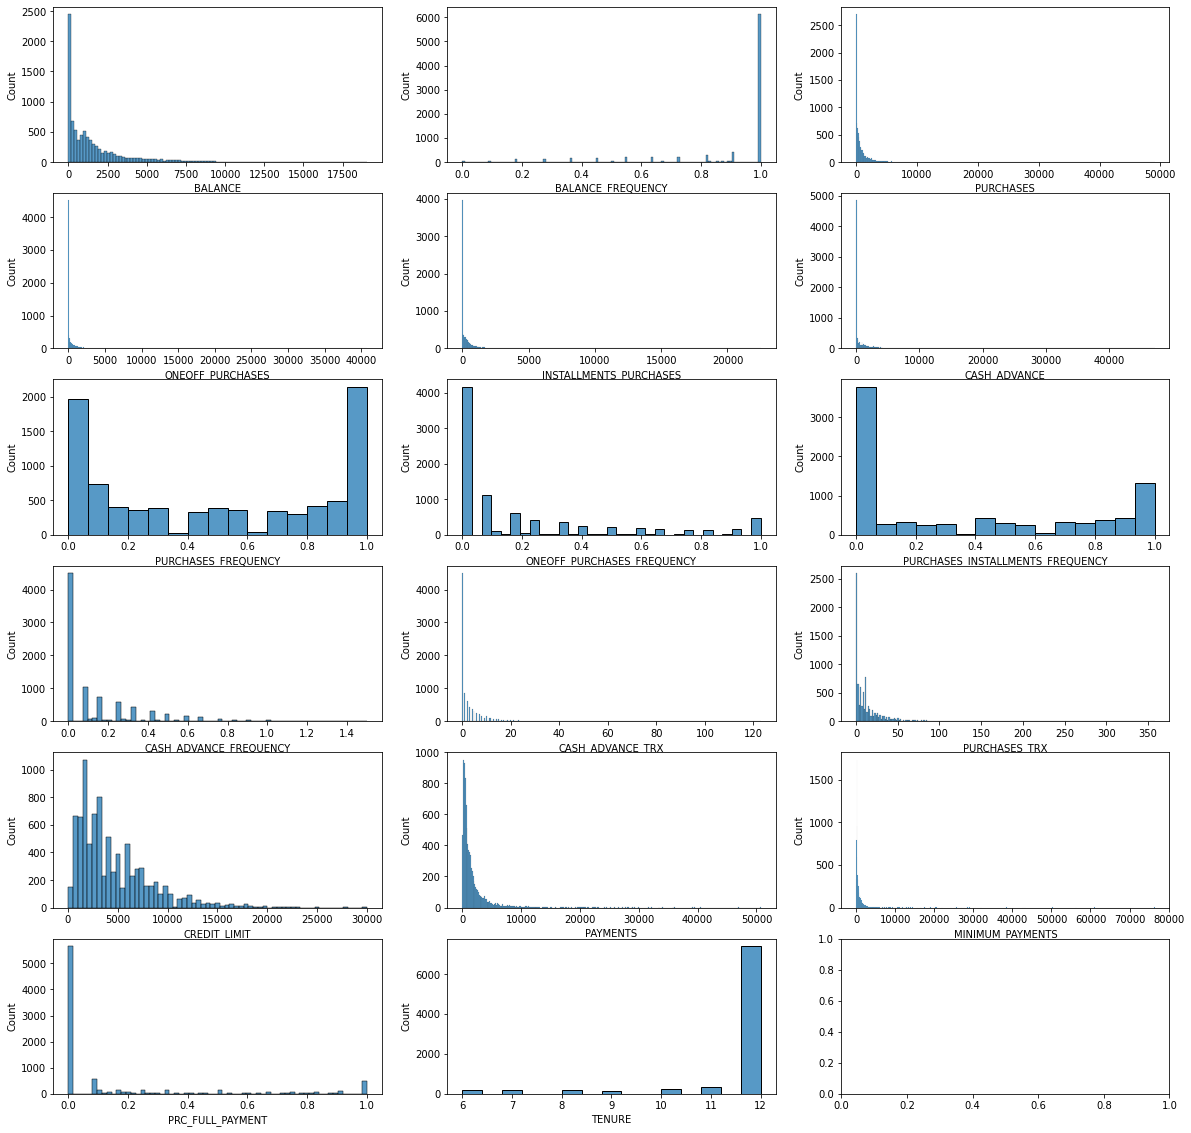

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

In [15]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))

for ax, column in zip(axs.flat, CC_df.columns):
    sns.histplot(data=CC_df[column] , ax=ax)
    plt.figure(figsize=(3,3))
plt.show()

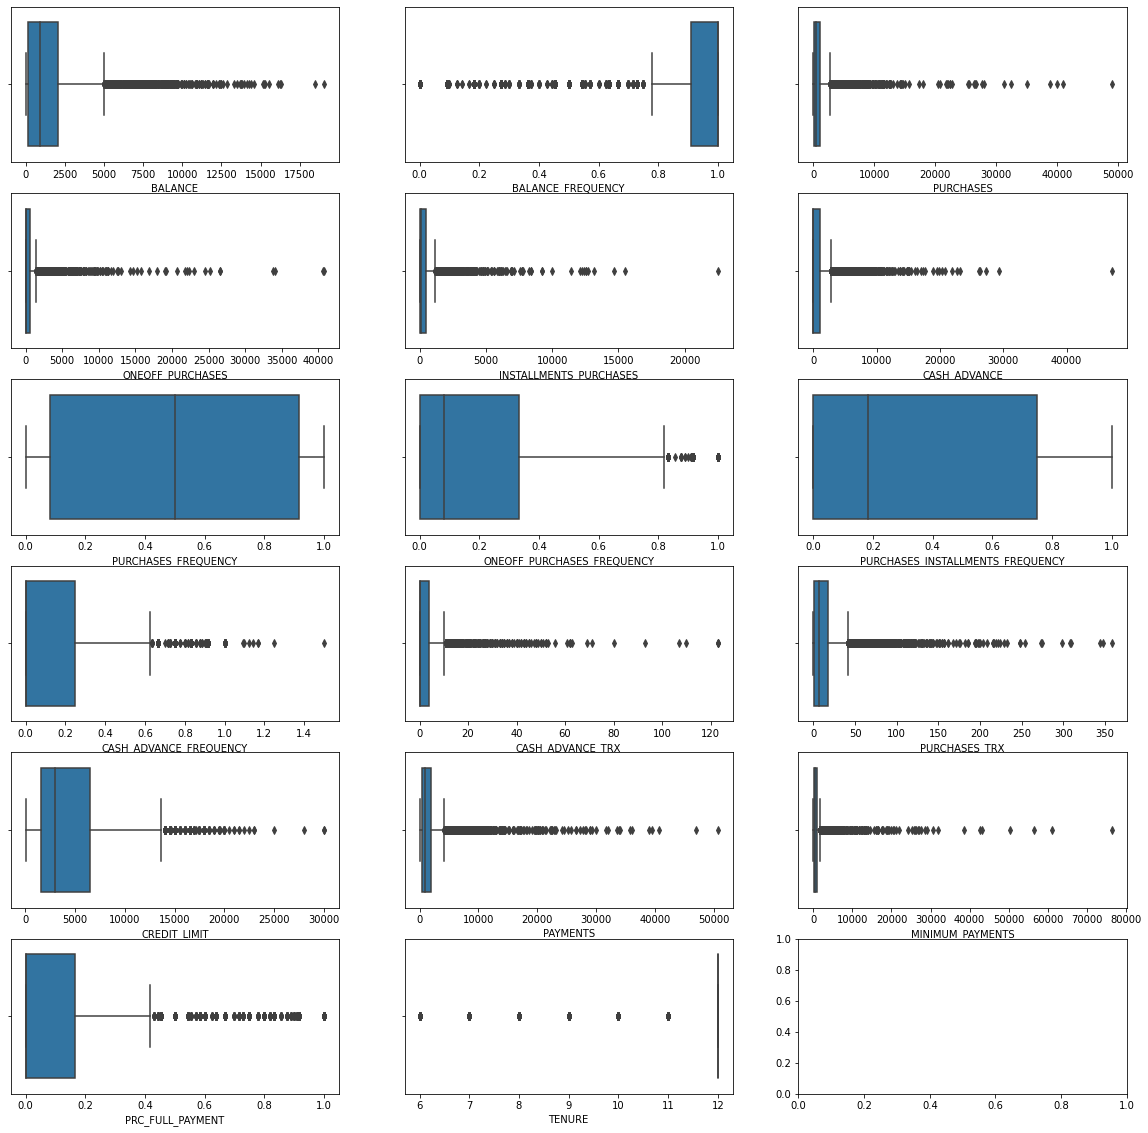

In [16]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))

for ax, column in zip(axs.flat, CC_df.columns):
    sns.boxplot(x=CC_df[column], ax=ax)
plt.show()

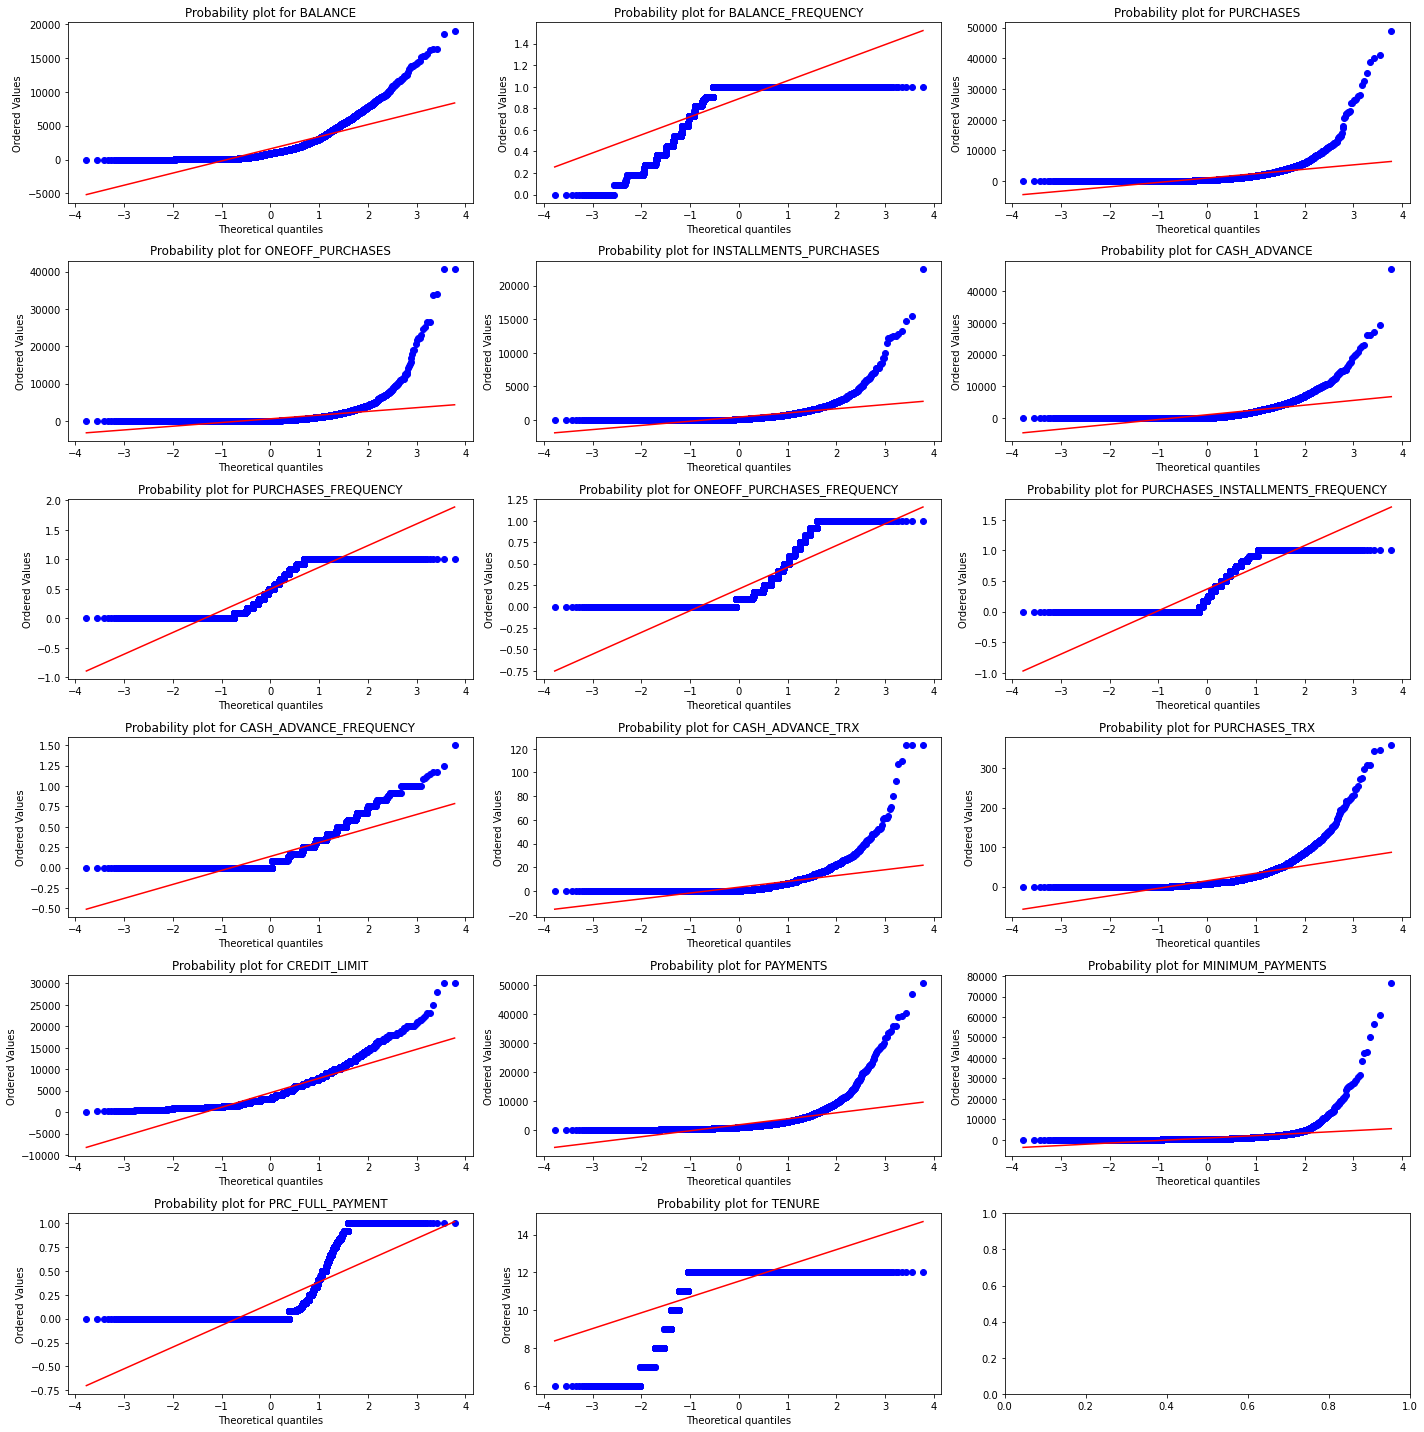

In [17]:
# plot probability plots for each column
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))

for ax, column in zip(axs.flat, CC_df.columns):
    stats.probplot(CC_df[column], plot=ax)
    ax.set_title(f'Probability plot for {column}')

plt.tight_layout()
plt.show()

In [18]:
# so from the probability plot I will make log transformation for the Skewed features 

In [19]:
# CC_columns_to_Log_Transformation=['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
#                                   'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_TRX',
#                                   'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']
# for col in CC_columns_to_Log_Transformation:
#     CC_df[col] = np.log(1 + CC_df[col])

In [20]:
# # After handling skweenes cols
# plt.figure(figsize=(15,20))
# for i, col in enumerate(CC_columns_to_Log_Transformation):
#     ax = plt.subplot(6, 2, i+1)
#     sns.kdeplot(CC_df[col], ax=ax)
# plt.show()

In [21]:
CC_columns_to_scale = ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY',
        'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

In [22]:
scaler = RobustScaler()

CC_df_scaled = pd.DataFrame(scaler.fit_transform(CC_df), columns=CC_df.columns)


In [23]:
CC_df_scaled.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8.710000e+03,8710.000000,8710.000000,8710.000000,8.710000e+03,8710.000000,8710.000000,8710.000000,8710.000000,8710.000000,8710.000000,8710.000000,8710.000000,8.710000e+03,8710.000000,8710.000000,8710.000000
mean,3.523984e-01,-1.225568,0.594833,0.948057,6.735609e-01,0.883207,-0.004772,0.363579,0.250229,0.546251,0.821728,0.497367,0.308172,5.834274e-01,0.849561,0.947699,-0.467623
std,1.076917e+00,2.413868,1.984109,2.844307,1.903721e+00,1.893822,0.481460,0.898097,0.530988,0.805120,1.722332,1.568184,0.745250,1.912417e+00,3.668480,1.772226,1.313888
min,-4.649799e-01,-11.000011,-0.341950,-0.070508,-1.989479e-01,0.000000,-0.600000,-0.249999,-0.242424,0.000000,0.000000,-0.437500,-0.602041,-5.828557e-01,-0.484870,0.000000,-6.000000
25%,-3.941065e-01,-1.000000,-0.300599,-0.070508,-1.989479e-01,0.000000,-0.500000,-0.249999,-0.242424,0.000000,0.000000,-0.375000,-0.285714,-3.111626e-01,-0.221373,0.000000,0.000000
50%,-2.925991e-17,0.000000,0.000000,0.000000,-1.481291e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.722879e-17,0.000000,0.000000,0.000000
75%,6.058935e-01,0.000000,0.699401,0.929492,8.010521e-01,1.000000,0.500000,0.750001,0.757576,1.000000,1.000000,0.625000,0.714286,6.888374e-01,0.778627,1.000000,0.000000
max,9.339021e+00,0.000000,44.721037,69.016356,4.667605e+01,42.221928,0.600000,2.750004,1.090909,6.000000,30.750000,21.937500,5.510204,3.263473e+01,118.132312,5.999988,0.000000


In [24]:
CC_df_scaled

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.443923,-2.000000,-0.254286,-0.070508,-0.000198,0.000000,-0.399999,-0.249999,-0.131313,0.000000,0.0,-0.3125,-0.408163,-0.450727,-0.268317,0.000000,0.0
1,1.183750,-1.000000,-0.341950,-0.070508,-0.198948,5.771100,-0.600000,-0.249999,-0.242424,1.000000,1.0,-0.4375,0.816327,2.104198,1.179860,1.333329,0.0
2,0.819600,0.000000,0.368525,1.239949,-0.198948,0.000000,0.600000,2.750004,-0.242424,0.000000,0.0,0.3125,0.918367,-0.175495,0.488932,0.000000,0.0
3,-0.043995,0.000000,-0.327247,-0.043390,-0.198948,0.000000,-0.500000,0.000000,-0.242424,0.000000,0.0,-0.3750,-0.367347,-0.138645,-0.104873,0.000000,0.0
4,0.466776,0.000000,0.883216,-0.070508,2.578719,0.000000,0.200000,-0.249999,0.535353,0.000000,0.0,0.0625,-0.244898,0.334013,3.252242,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,-0.450311,0.000000,-0.074436,-0.070508,0.407552,0.000000,0.600000,-0.249999,0.868687,0.000000,0.0,-0.0625,-0.408163,-0.369656,-0.409006,2.999994,-6.0
8706,-0.455104,0.000000,-0.066276,-0.070508,0.426052,0.000000,0.600000,-0.249999,0.868687,0.000000,0.0,-0.0625,-0.408163,-0.402226,0.000000,0.000000,-6.0
8707,-0.452934,-1.833339,-0.209259,-0.070508,0.101885,0.000000,0.399999,-0.249999,0.646465,0.000000,0.0,-0.1250,-0.408163,-0.529664,-0.356949,1.499997,-6.0
8708,-0.458052,-1.833339,-0.341950,-0.070508,-0.198948,0.032747,-0.600000,-0.249999,-0.242424,0.666668,0.5,-0.4375,-0.510204,-0.548473,-0.398342,1.499997,-6.0


In [25]:
CC_df_scaled.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

### Finds Corrolation between coloums

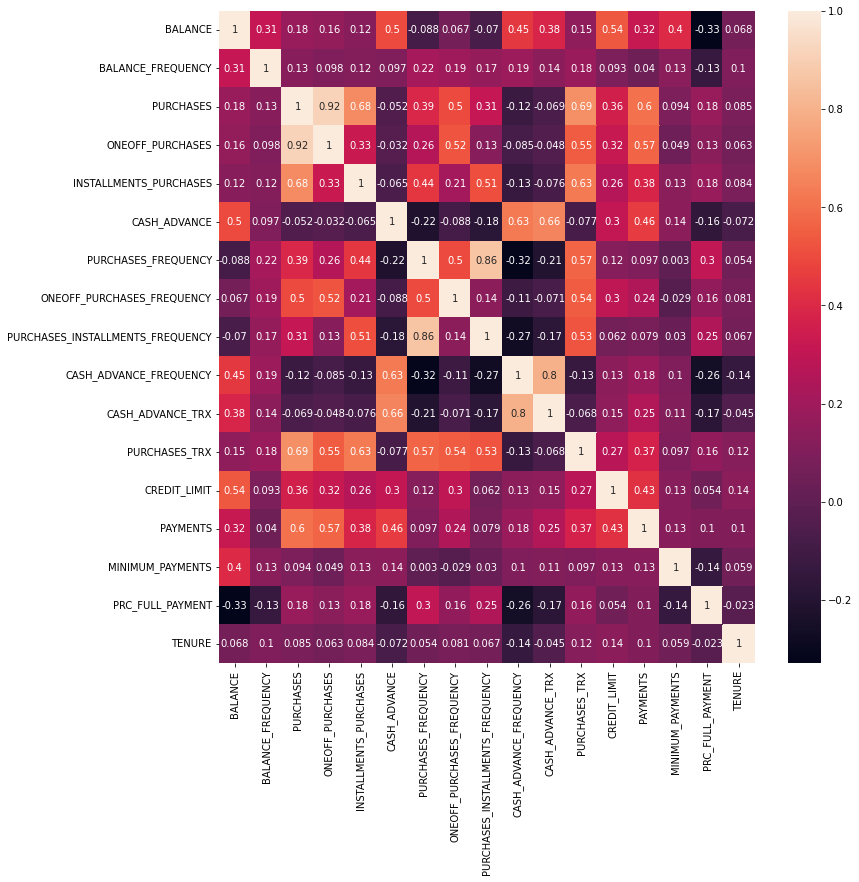

In [26]:
plt.figure(figsize=(12,12))
sns.heatmap(CC_df_scaled.corr(), annot=True)
plt.show()

### Applying PCA

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
CC_df_transformed = pca.fit_transform(CC_df_scaled)
CC_df_transformed = pd.DataFrame(CC_df_transformed)

In [28]:
CC_df_transformed.head()

,0,1,2,3,4,5,6,7,8
0,-2.618026,-0.140228,-1.055085,-0.083134,0.839390,0.837156,0.541866,-0.096307,0.492844
1,-0.315897,1.809036,3.748060,1.813163,-0.775006,-1.137777,1.587174,-1.563767,-1.063562
2,-0.200762,-0.303742,-0.315267,-1.837715,1.572590,0.196672,0.532284,0.271257,-1.219270
3,-2.141472,0.185748,-0.213114,-1.712258,1.034136,0.304061,0.773749,-0.498064,0.501491
4,1.087400,2.159523,-1.440595,-1.694380,-0.966480,1.334779,0.421442,-0.744652,1.181650


## **Clustering & Comparing Model**

### Determining Best k

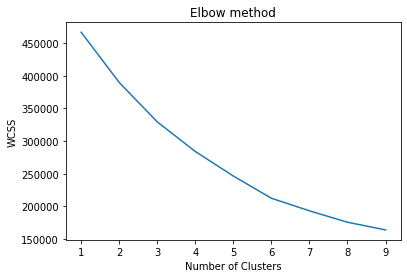

In [29]:
kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(CC_df_transformed) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

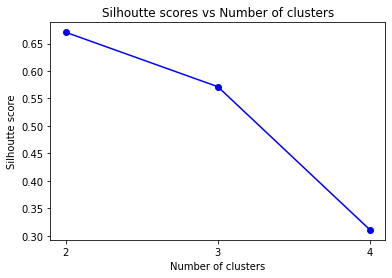

In [54]:
silhoutte_scores = [silhouette_score(CC_df_transformed, model.labels_) for model in kmeans_models[1:4]]
plt.plot(range(2,5), silhoutte_scores, "bo-")
plt.xticks([2, 3, 4])
plt.title('Silhoutte scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

### **KMeans**

In [31]:
kmeans = KMeans(n_clusters=2, random_state=23).fit(CC_df_transformed)
CC_df_transformed["KMeans"] = kmeans.labels_
print('Silhoutte score of kmeans model is ' + str(silhouette_score(CC_df_transformed, kmeans.labels_)))

Silhoutte score of kmeans model is 0.6702514152509594


### **DBSCAN**

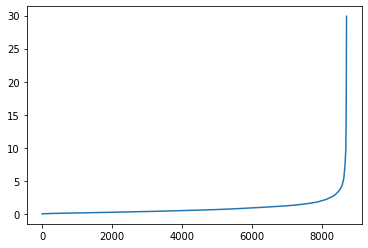

In [32]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(CC_df_transformed)
distances, indices = neighbors_fit.kneighbors(CC_df_transformed)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [53]:
dbscan = DBSCAN(eps=57, min_samples=150)
labels = dbscan.fit_predict(CC_df_transformed)
s = silhouette_score(CC_df_transformed, labels)
print(s)

0.933399208656443


### **Hierarchy**

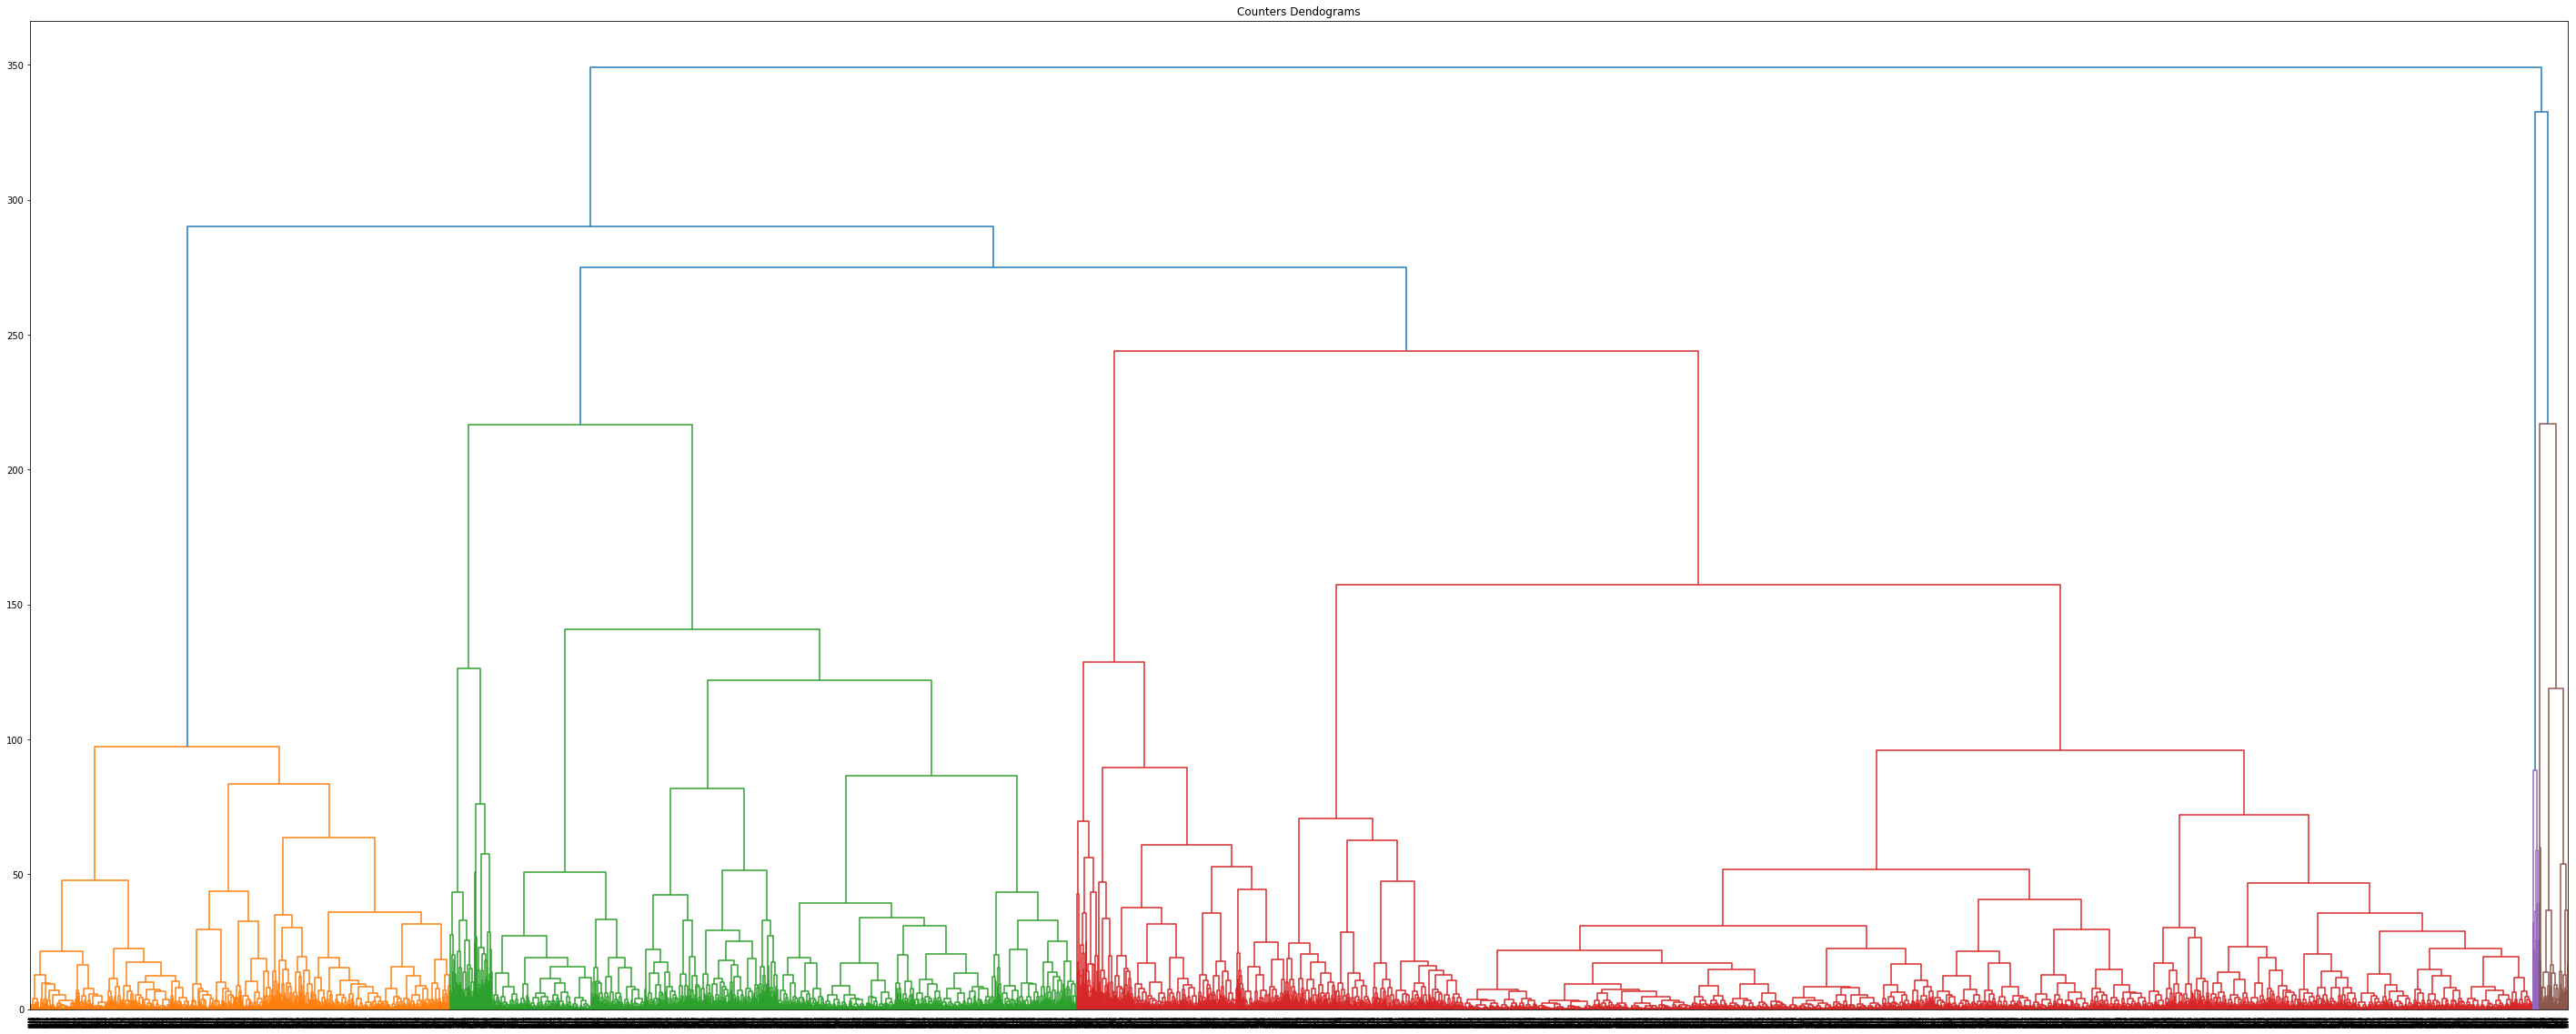

In [37]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(50, 20))
plt.title("Counters Dendograms")
dend = shc.dendrogram(shc.linkage(y=CC_df_transformed, method='ward',metric='euclidean'),orientation='top') #fill y with your dataframe


In [38]:
hc = AgglomerativeClustering(n_clusters=3).fit(CC_df_transformed)

# Prints the labels for each example
hc_labels = hc.labels_
sil_hc=silhouette_score(CC_df_transformed, hc_labels)
print(sil_hc)

0.7213206539670092


### **GaussianMixture**

In [35]:
gmm=GaussianMixture(n_components=2).fit(CC_df_transformed) 
labels=gmm.predict(CC_df_transformed)
sil=silhouette_score(CC_df_transformed, labels)
print(sil)

0.670692210502323


## **Conclusion**
 **DBSCAN gives us the best score**